In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from sleeprnn.data import utils

# Original wavelet

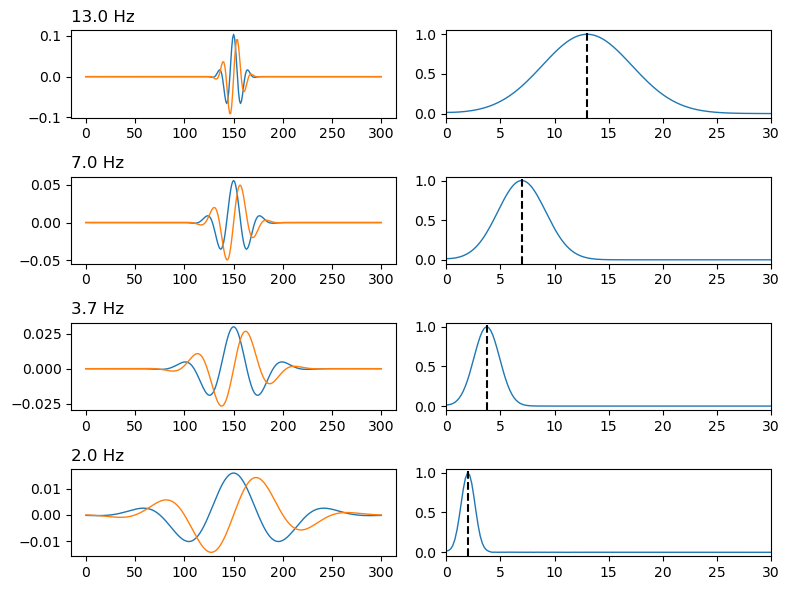

In [41]:
fs = 200
upper_freq = 13
lower_freq = 2
n_scales = 4
size_factor = 1.0
beta = 0.5

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
one_side = size_factor * int(scales[-1] * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    norm_constant = np.sqrt(np.pi * beta) * scale * fs / 2.0
    exp_term = np.exp(-((k_array / scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz" % frequencies[i], loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

# Wavelet with expansion factor

kernel size 529.0


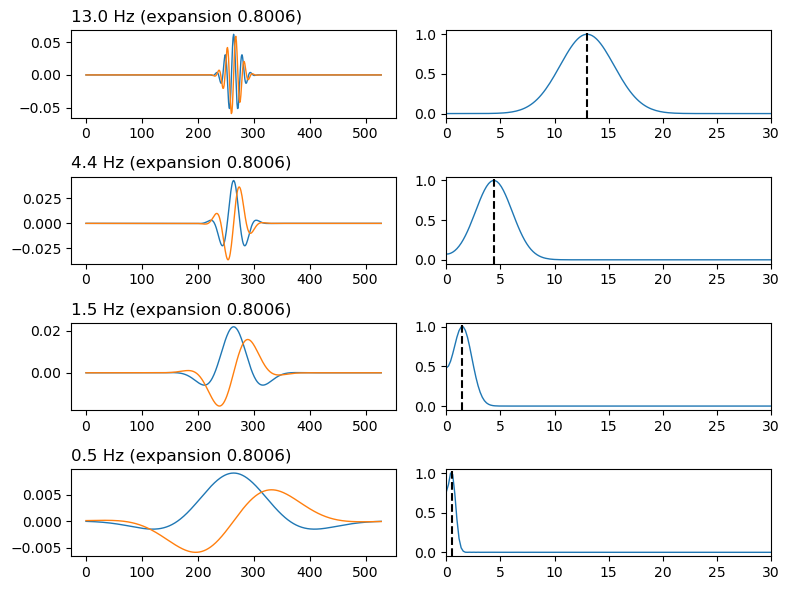

In [105]:
fs = 200
upper_freq = 13
lower_freq = 0.5
n_scales = 4
size_factor = 1.0
beta = 0.1201

logit_expansion_factor = 1.39  # 1.39 -> 0.8; 2.2 -> 0.9
expansion_factor = 1 / (1 + np.exp(-logit_expansion_factor))

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
largest_scale = scales[-1]
largest_scale_expanded = expansion_factor * largest_scale + (1 - expansion_factor)
one_side = size_factor * int(largest_scale_expanded * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
print("kernel size", kernel_size)
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    expanded_scale = expansion_factor * scale + (1 - expansion_factor)
    norm_constant = np.sqrt(np.pi * beta) * expanded_scale * fs / 2.0
    exp_term = np.exp(-((k_array / expanded_scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz (expansion %1.4f)" % (frequencies[i], expansion_factor), loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

kernel size 863.0


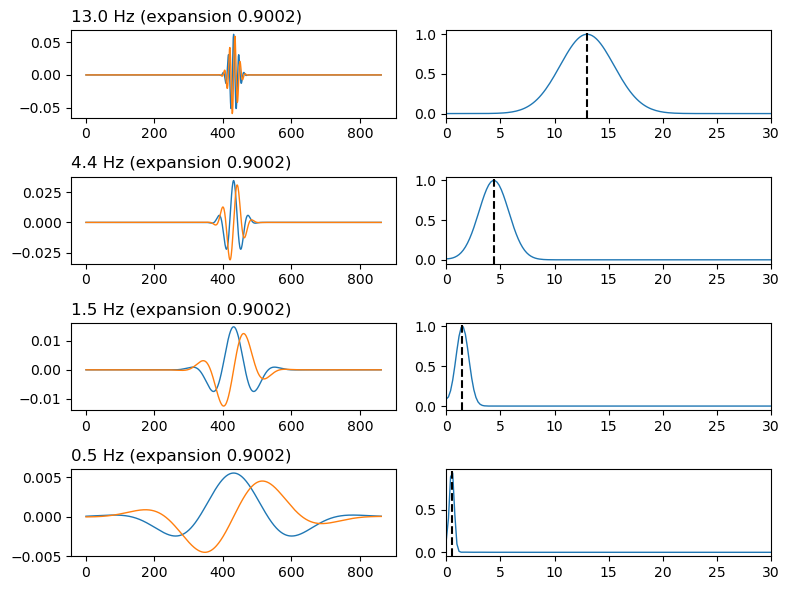

In [120]:
fs = 200
upper_freq = 13
lower_freq = 0.5
n_scales = 4
size_factor = 1.0
beta = 0.287

logit_expansion_factor = 2.2  # 1.39 -> 0.8; 2.2 -> 0.9
expansion_factor = 1 / (1 + np.exp(-logit_expansion_factor))

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
largest_scale = scales[-1]
largest_scale_expanded = expansion_factor * largest_scale + (1 - expansion_factor)
one_side = size_factor * int(largest_scale_expanded * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
print("kernel size", kernel_size)
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    expanded_scale = expansion_factor * scale + (1 - expansion_factor)
    norm_constant = np.sqrt(np.pi * beta) * expanded_scale * fs / 2.0
    exp_term = np.exp(-((k_array / expanded_scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz (expansion %1.4f)" % (frequencies[i], expansion_factor), loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

In [42]:
def beta_from_cycles(n, q, frec):
    s = 1 / frec
    main_term = n ** 2 / 18
    q_adjust = (s / (s * q +1 - q)) ** 2
    return main_term * q_adjust

In [116]:
beta = beta_from_cycles(n=5, q=0.9, frec=13)
print("Beta %1.4f" % beta)

Beta 0.2870


In [54]:
def logit_from_proba(p):
    l = np.log(p / (1 - p))
    return l

In [78]:
logit_from_proba(0.98)

3.8918202981106256

In [68]:
5/15

0.3333333333333333

In [107]:
def cycles_from_beta(beta, q, frec):
    s = 1 / frec
    s_expanded = s * q + (1 - q)
    cycles = 2 * s_expanded * np.sqrt(4.5 * beta) * frec
    return cycles

In [119]:
cycles_from_beta(0.2870, 0.9, 3)

2.7274603571821165